In [1]:
# Import general modules used for e.g. plotting.
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch

# Import auxiliary modules.
from distutils.version import LooseVersion
from typing import Optional, Tuple

# Importing PyTorch specific modules.
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Conv2d, Dropout, Linear, MaxPool2d, Module, ReLU, Sequential, Sigmoid
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.utils.data import DataLoader

#for MnistBags
import numpy as np
import torch
import torch.utils.data as data_utils
from torchvision import datasets, transforms

# Set plotting style.
sns.set()

C:\Users\Ahmed Lone\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
python_check = '(\u2713)' if sys.version_info >= (3, 8) else '(\u2717)'
pytorch_check = '(\u2713)' if torch.__version__ >= LooseVersion(r'1.5') else '(\u2717)'

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro} {python_check}')
print(f'Installed PyTorch version: {torch.__version__} {pytorch_check}')

Installed Python version:  3.8.3 (✓)
Installed PyTorch version: 1.13.0 (✓)


C:\Users\Ahmed Lone\AppData\Local\Temp\ipykernel_7640\3801270298.py:2: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  pytorch_check = '(\u2713)' if torch.__version__ >= LooseVersion(r'1.5') else '(\u2717)'


In [4]:
class MnistBags(data_utils.Dataset):
    def __init__(self, target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=250, seed=1, train=True):
        self.target_number = target_number
        self.mean_bag_length = mean_bag_length
        self.var_bag_length = var_bag_length
        self.num_bag = num_bag
        self.train = train

        self.r = np.random.RandomState(seed)

        self.num_in_train = 60000
        self.num_in_test = 10000

        if self.train:
            self.train_bags_list, self.train_labels_list = self._create_bags()
        else:
            self.test_bags_list, self.test_labels_list = self._create_bags()

    def _create_bags(self):
        if self.train:
            loader = data_utils.DataLoader(datasets.MNIST('../datasets',
                                                          train=True,
                                                          download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=self.num_in_train,
                                           shuffle=False)
        else:
            loader = data_utils.DataLoader(datasets.MNIST('../datasets',
                                                          train=False,
                                                          download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=self.num_in_test,
                                           shuffle=False)

        for (batch_data, batch_labels) in loader:
            all_imgs = batch_data
            all_labels = batch_labels

        bags_list = []
        labels_list = []

        for i in range(self.num_bag):
            bag_length = np.int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1))
            if bag_length < 1:
                bag_length = 1

            if self.train:
                indices = torch.LongTensor(self.r.randint(0, self.num_in_train, bag_length))
            else:
                indices = torch.LongTensor(self.r.randint(0, self.num_in_test, bag_length))

            labels_in_bag = all_labels[indices]
            labels_in_bag = labels_in_bag == self.target_number

            bags_list.append(all_imgs[indices])
            labels_list.append(labels_in_bag)

        return bags_list, labels_list

    def __len__(self):
        if self.train:
            return len(self.train_labels_list)
        else:
            return len(self.test_labels_list)

    def __getitem__(self, index):
        if self.train:
            bag = self.train_bags_list[index]
            label = [max(self.train_labels_list[index]), self.train_labels_list[index]]
        else:
            bag = self.test_bags_list[index]
            label = [max(self.test_labels_list[index]), self.test_labels_list[index]]

        return bag, label


In [6]:
log_dir = 'C:/Users/Ahmed Lone/Desktop/IEOR/final_project/logs'
os.makedirs(log_dir, exist_ok=True)

In [285]:
def batch_matrix_similarity(tensor, eps=1e-8):
    matrices = []
    for matrix in tensor[0]:
        matrices.append(matrix[0])
    similarities = []
    for x, y in itertools.combinations(matrices, 2):
        x_norm = x.norm(dim=1)[:, None]
        y_norm = y.norm(dim=1)[:, None]        
        x_norm = x / torch.max(x_norm, eps * torch.ones_like(x_norm))
        y_norm = y / torch.max(y_norm, eps * torch.ones_like(y_norm))
        similarity = torch.mm(x_norm, y_norm.transpose(0, 1))
        similarities.append(torch.mean(similarity))
        #print("similarity is")
        #print(similarity)
    return float(sum(similarities) / len(similarities))


In [801]:
def train_epoch(network: Module,
                optimiser: AdamW,
                data_loader: DataLoader
               ) -> Tuple[float, float, float]:
    """
    Execute one training epoch.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader: data loader instance providing training data
    :return: tuple comprising training loss, training error as well as accuracy
    """
    network.train()
    losses, errors, accuracies = [], [], []
    batch_data = []
    for data, target in data_loader:
        data, target = data.to(device=device), target[0].to(device=device)

        # Process data by Hopfield-based network.
        loss = network.calculate_objective(data, target)[0]

        # Update network parameters.
        optimiser.zero_grad()
        loss.backward()
        clip_grad_norm_(parameters=network.parameters(), max_norm=1.0, norm_type=2)
        optimiser.step()

        # Compute performance measures of current model.
        error, prediction = network.calculate_classification_error(data, target)
        accuracy = (prediction == target).to(dtype=torch.float32).mean()
        accuracies.append(accuracy.detach().item())
        errors.append(error)
        losses.append(loss.detach().item())
        
        #for the given data, calc the training value. Place in dict w/ error, predition and accuracy
        #we can then bucket matrix similarity and judge avg error, prediction, accuracy per batch? or alternatively scatter plot, linear regression, etc. 
        batch_data.append([batch_matrix_similarity(data), data.shape[1], loss.detach().item(), error, accuracy.detach().item()])
        if batch_matrix_similarity(data) > 0.24:
            global to_save
            to_save = data
    
    # Report progress of training procedure.
    return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies), batch_data


def eval_iter(network: Module,
              data_loader: DataLoader
             ) -> Tuple[float, float, float]:
    """
    Evaluate the current model.
    
    :param network: network instance to evaluate
    :param data_loader: data loader instance providing validation data
    :return: tuple comprising validation loss, validation error as well as accuracy
    """
    network.eval()
    with torch.no_grad():
        losses, errors, accuracies = [], [], []
        batch_data = []
        for data, target in data_loader:
            data, target = data.to(device=device), target[0].to(device=device)
            
            # Process data by Hopfield-based network.
            loss = network.calculate_objective(data, target)[0]

            # Compute performance measures of current model.
            error, prediction = network.calculate_classification_error(data, target)
            accuracy = (prediction == target).to(dtype=torch.float32).mean()
            accuracies.append(accuracy.detach().item())
            errors.append(error)
            losses.append(loss.detach().item())

            batch_data.append([batch_matrix_similarity(data), data.shape[1], loss.detach().item(), error, accuracy.detach().item()])
        
        # Report progress of validation procedure.
        return sum(losses) / len(losses), sum(errors) / len(errors), sum(accuracies) / len(accuracies), batch_data

    
def operate(network: Module,
            optimiser: AdamW,
            data_loader_train: DataLoader,
            data_loader_eval: DataLoader,
            num_epochs: int = 1
           ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Train the specified network by gradient descent using backpropagation.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader_train: data loader instance providing training data
    :param data_loader_eval: data loader instance providing validation data
    :param num_epochs: amount of epochs to train
    :return: data frame comprising training as well as evaluation performance
    """
    losses, errors, accuracies = {r'train': [], r'eval': []}, {r'train': [], r'eval': []}, {r'train': [], r'eval': []}
    batches = {r'train': [], r'eval': []}
    for epoch in range(num_epochs):
        
        # Train network.
        performance = train_epoch(network, optimiser, data_loader_train)
        losses[r'train'].append(performance[0])
        errors[r'train'].append(performance[1])
        accuracies[r'train'].append(performance[2])
        batches[r'train'].append(performance[3])
        
        # Evaluate current model.
        performance = eval_iter(network, data_loader_eval)
        losses[r'eval'].append(performance[0])
        errors[r'eval'].append(performance[1])
        accuracies[r'eval'].append(performance[2])
        batches[r'eval'].append(performance[3])
        
    # Report progress of training and validation procedures.
    return pd.DataFrame(losses), pd.DataFrame(errors), pd.DataFrame(accuracies), batches

In [8]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.
    
    :param seed: seed to be used
    :return: None
    """
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def plot_performance(loss: pd.DataFrame,
                     error: pd.DataFrame,
                     accuracy: pd.DataFrame,
                     log_file: str
                    ) -> None:
    """
    Plot and save loss and accuracy.
    
    :param loss: loss to be plotted
    :param error: error to be plotted
    :param accuracy: accuracy to be plotted
    :param log_file: target file for storing the resulting plot
    :return: None
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    
    loss_plot = sns.lineplot(data=loss, ax=ax[0])
    loss_plot.set(xlabel=r'Epoch', ylabel=r'Loss')
    
    error_plot = sns.lineplot(data=error, ax=ax[1])
    error_plot.set(xlabel=r'Epoch', ylabel=r'Error')
    
    accuracy_plot = sns.lineplot(data=accuracy, ax=ax[2])
    accuracy_plot.set(xlabel=r'Epoch', ylabel=r'Accuracy')
    
    fig.tight_layout()
    fig.savefig(log_file)
    plt.show(fig)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)  # NxL

        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A

    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A


In [10]:
# Hopsfield network prototype

In [1041]:
import torch
import torch.nn as nn

from torch import Tensor
from typing import Optional, Tuple, Union
from functools import partial
from scipy.stats import ortho_group
from einops import rearrange, repeat

def hopfield_core_forward(query,                           # type: Tensor
                          key,                             # type: Tensor
                          value,                           # type: Tensor
                          embed_dim_to_check,              # type: int
                          num_heads,                       # type: int
                          in_proj_weight,                  # type: Optional[Tensor]
                          in_proj_bias,                    # type: Optional[Tensor]
                          bias_k,                          # type: Optional[Tensor]
                          bias_v,                          # type: Optional[Tensor]
                          add_zero_attn,                   # type: bool
                          dropout_p,                       # type: float
                          out_proj_weight,                 # type: Tensor
                          out_proj_bias,                   # type: Tensor
                          training=True,                   # type: bool
                          key_padding_mask=None,           # type: Optional[Tensor]
                          need_weights=True,               # type: bool
                          attn_mask=None,                  # type: Optional[Tensor]
                          use_separate_proj_weight=False,  # type: bool
                          q_proj_weight=None,              # type: Optional[Tensor]
                          k_proj_weight=None,              # type: Optional[Tensor]
                          v_proj_weight=None,              # type: Optional[Tensor]
                          static_k=None,                   # type: Optional[Tensor]
                          static_v=None,                   # type: Optional[Tensor]

                          key_as_static=False,             # type: bool
                          query_as_static=False,           # type: bool
                          value_as_static=False,           # type: bool
                          value_as_connected=False,        # type: bool
                          normalize_pattern=False,         # type: bool
                          normalize_pattern_eps=1e-5,      # type: float
                          p_norm_weight=None,              # type: Optional[Tensor]
                          p_norm_bias=None,                # type: Optional[Tensor]
                          head_dim=None,                   # type: Optional[int]
                          pattern_dim=None,                # type: Optional[int]
                          scaling=None,                    # type: Optional[Union[float, Tensor]]
                          update_steps_max=0,              # type: Optional[Union[int, Tensor]]
                          update_steps_eps=1e-4,           # type: Union[float, Tensor]
                          return_raw_associations=False,   # type: bool
                          return_projected_patterns=False  # type: bool
                          ):
    # type: (...) -> Tuple[Tensor, Optional[Tensor]]
    r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
            See "Hopfield Networks is All You Need" for more details in the setting of Hopfield networks.
        embed_dim_to_check: total dimension of the model (in case of default head dimension).
        num_heads: parallel attention heads.
        in_proj_weight, in_proj_bias: input projection weight and bias.
        bias_k, bias_v: bias of the key and value sequences to be added at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        dropout_p: probability of an element to be zeroed.
        out_proj_weight, out_proj_bias: the output projection weight and bias.
        training: apply dropout if is ``True``.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
        use_separate_proj_weight: the function accept the proj. weights for query, key,
            and value in different forms. If false, in_proj_weight will be used, which is
            a combination of q_proj_weight, k_proj_weight, v_proj_weight.
        q_proj_weight, k_proj_weight, v_proj_weight, in_proj_bias: input projection weight and bias.
        static_k, static_v: static key and value used for attention operators.

        key_as_static: interpret specified key as being static.
        query_as_static: interpret specified key as being static.
        value_as_static: interpret specified key as being static.
        value_as_connected: connect value projection with key projection.
        normalize_pattern: enable normalization of patterns.
        normalize_pattern_eps: offset of the denominator for numerical stability.
        p_norm_weight, p_norm_bias: pattern normalization weight and bias.
        head_dim: dimensionality of each head.
        pattern_dim: dimensionality of each projected value input.
        scaling: scaling of association heads, often represented as beta (one entry per head).
        update_steps_max: maximum count of association update steps (None equals to infinity).
        update_steps_eps: minimum difference threshold between two consecutive association update steps.
        return_raw_associations: return raw association (softmax) values, unmodified.
        return_projected_patterns: return pattern projection values, unmodified.

    Shape:
        Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the zero positions
          will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensures that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - static_k: :math:`(N*num_heads, S, head_dim)`, where S is the source sequence length, N is the batch size.
        - static_v: :math:`(N*num_heads, S, head_dim)`, where S is the source sequence length, N is the batch size.

        - scaling: :math:`(num_heads,)`, where num_heads is the amount of heads.

        Outputs:
        - attn_output: :math:`(L, N, E)`, where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)`, where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        - attn_raw: :math:``(N, num_heads, L, S)`, where N is the batch size,
          L is the target sequence length, S is the source sequence length.
    """
#     print("key stats are: " + str(key.shape))
#     print(key)
#     print("query stats are: " + str(query.shape))
#     print(query)

    if not torch.jit.is_scripting():
        tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v,
                    out_proj_weight, out_proj_bias)
        if any([type(t) is not Tensor for t in tens_ops]) and nn.functional.has_torch_function(tens_ops):
            return nn.functional.handle_torch_function(
                hopfield_core_forward, tens_ops, query, key, value,
                embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                bias_k, bias_v, add_zero_attn, dropout_p, out_proj_weight,
                out_proj_bias, training=training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=use_separate_proj_weight,
                q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight,
                v_proj_weight=v_proj_weight, static_k=static_k, static_v=static_v,
                key_as_static=key_as_static, query_as_static=query_as_static,
                value_as_static=value_as_static, value_as_connected=value_as_connected,
                normalize_pattern=normalize_pattern, normalize_pattern_eps=normalize_pattern_eps,
                p_norm_weight=p_norm_weight, p_norm_bias=p_norm_bias,
                head_dim=head_dim, pattern_dim=pattern_dim, scaling=scaling, update_steps_max=update_steps_max,
                update_steps_eps=update_steps_eps, return_raw_associations=return_raw_associations)
    tgt_len, bsz, embed_dim = query.shape[0], value.shape[1], query.shape[2]
    assert embed_dim == embed_dim_to_check
    # allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

    assert (scaling is None) or (type(scaling) in (float, torch.Tensor))
    if type(scaling) == torch.Tensor:
        assert scaling.ndimension() == 1 and scaling.shape[0] == num_heads, "only one entry per head."

    assert (update_steps_max is None) or (type(update_steps_max) in (int, torch.Tensor))
    if type(update_steps_max) == torch.Tensor:
        assert update_steps_max.ndimension() == 1 and update_steps_max.shape[0] == num_heads, "only one entry per head."
    elif type(update_steps_max) == int:
        update_steps_max = torch.tensor([update_steps_max] * num_heads, dtype=torch.int32, device=query.device)
    elif update_steps_max is None:
        update_steps_max = -torch.ones(size=(num_heads,), dtype=torch.int32, device=query.device)

    assert type(update_steps_eps) in (float, torch.Tensor)
    if type(update_steps_eps) == torch.Tensor:
        assert update_steps_eps.ndimension() == 1 and update_steps_eps.shape[0] == num_heads, "only one entry per head."
        assert (update_steps_eps <= 0.0).sum() == 0, "only positive thresholds allowed."
        update_steps_eps = update_steps_eps.to(device=query.device)
    elif type(update_steps_eps) == float:
        assert update_steps_eps > 0, "only positive thresholds allowed."
        update_steps_eps = torch.tensor([update_steps_eps] * num_heads, dtype=query.dtype, device=query.device)

    # Adapt dimensionality of each each.
    if head_dim is None:
        head_dim = embed_dim // num_heads
        assert head_dim * num_heads == embed_dim, r'embed_dim must be divisible by num_heads.'
    hopfield_dim = num_heads * head_dim

    # Adapt dimensionality of each value projection.
    if pattern_dim is None:
        pattern_dim = head_dim
    assert (not value_as_connected) or (pattern_dim == head_dim)

    q, k, v, xi, src_len = None, None, None, None, 0
    update_step, xi_old, xi_difference_norm = 0, None, float(r'+inf')
    update_active_heads = torch.tensor([[[True]]] * num_heads * bsz, device=query.device)
    assert update_active_heads.any(), "at least one head needs to be active."

    ####################################################################################################################
    #                                         BEGIN HOPFIELD UPDATE ITERATION                                          #
    ####################################################################################################################
    while update_active_heads.any():

        # The query is already projected into the "Hopfield" space at "update_step" equals 0.
        # No more projection necessary if "update_step" greater than 0.
        if update_step == 0:
            if not use_separate_proj_weight:

                if torch.equal(query, key) and torch.equal(key, value) and not (
                        key_as_static or query_as_static or value_as_static):
                    # self-attention
                    q, k, v = nn.functional.linear(query, in_proj_weight, in_proj_bias).chunk(3, dim=-1)

                elif torch.equal(key, value) and not (key_as_static or value_as_static):
                    # encoder-decoder attention
                    _start, _end = 0, hopfield_dim
                    if query_as_static:
                        q = query.repeat(1, num_heads, 1)
                    else:
                        # This is inline in_proj function with in_proj_weight and in_proj_bias
                        _b = in_proj_bias
                        _w = in_proj_weight[_start:_end, :]
                        if _b is not None:
                            _b = _b[_start:_end]
                        q = nn.functional.linear(query, _w, _b)
                        _start = hopfield_dim
                    _end = None

                    if key is None:
                        assert value is None
                        k = None
                        v = None
                    else:

                        # This is inline in_proj function with in_proj_weight and in_proj_bias
                        _b = in_proj_bias
                        _w = in_proj_weight[_start:_end, :]
                        if _b is not None:
                            _b = _b[_start:_end]
                        k, v = nn.functional.linear(key, _w, _b).chunk(2, dim=-1)

                else:
                    _start, _end = 0, hopfield_dim
                    if query_as_static:
                        q = query.repeat(1, num_heads, 1)
                    else:
                        # This is inline in_proj function with in_proj_weight and in_proj_bias
                        _b = in_proj_bias
                        _w = in_proj_weight[_start:_end, :]
                        if _b is not None:
                            _b = _b[_start:_end]
                        q = nn.functional.linear(query, _w, _b)
                        _start += hopfield_dim
                        _end += hopfield_dim

                    if key_as_static:
                        k = key.repeat(1, num_heads, 1)
                    else:
                        # This is inline in_proj function with in_proj_weight and in_proj_bias
                        _b = in_proj_bias
                        _w = in_proj_weight[_start:_end, :]
                        if _b is not None:
                            _b = _b[_start:_end]
                        k = nn.functional.linear(key, _w, _b)
                        _start += hopfield_dim
                        _end += hopfield_dim

                    if value_as_static:
                        v = value.repeat(1, num_heads, 1)
                    else:
                        # This is inline in_proj function with in_proj_weight and in_proj_bias
                        _b = in_proj_bias
                        _w = in_proj_weight[_start:_end, :]
                        if _b is not None:
                            _b = _b[_start:_end]
                        v = nn.functional.linear(value, _w, _b)
            else:
                _start, _end = 0, hopfield_dim
                if query_as_static:
                    q = query.repeat(1, num_heads, 1)
                else:
                    q_proj_weight_non_opt = torch.jit._unwrap_optional(q_proj_weight)
                    len1, len2 = q_proj_weight_non_opt.size()
                    assert len1 == hopfield_dim and len2 == query.size(-1)
                    if in_proj_bias is not None:
                        q = nn.functional.linear(query, q_proj_weight_non_opt, in_proj_bias[_start:_end])
                        _start += hopfield_dim
                        _end += hopfield_dim
                    else:
                        q = nn.functional.linear(query, q_proj_weight_non_opt, in_proj_bias)

                v = value
                if key_as_static:
                    k = key.repeat(1, num_heads, 1)
                else:
                    k_proj_weight_non_opt = torch.jit._unwrap_optional(k_proj_weight)
                    len1, len2 = k_proj_weight_non_opt.size()
                    assert len1 == hopfield_dim and len2 == key.size(-1)

                    _bias = None if in_proj_bias is None else in_proj_bias[_start:_end]
                    k = nn.functional.linear(key, k_proj_weight_non_opt, _bias)
                    if value_as_connected:
                        v = nn.functional.linear(v, k_proj_weight_non_opt, _bias)
                    _start += hopfield_dim
                    _end += num_heads * pattern_dim

                if value_as_static:
                    if not (value_as_connected or key_as_static):
                        v = v.repeat(1, num_heads, 1)
                else:
                    v_proj_weight_non_opt = torch.jit._unwrap_optional(v_proj_weight)
                    len1, len2 = v_proj_weight_non_opt.size()
                    assert len1 == (num_heads * pattern_dim) and len2 == v.size(-1)
                    if in_proj_bias is not None:
                        v = nn.functional.linear(v, v_proj_weight_non_opt, in_proj_bias[_start:])
                    else:
                        v = nn.functional.linear(v, v_proj_weight_non_opt, in_proj_bias)

            if attn_mask is not None:
                assert attn_mask.dtype == torch.float32 or attn_mask.dtype == torch.float64 or \
                       attn_mask.dtype == torch.float16 or attn_mask.dtype == torch.uint8 or \
                       attn_mask.dtype == torch.bool, \
                       'Only float, byte, and bool types are supported for attn_mask, not {}'.format(attn_mask.dtype)
                if attn_mask.dtype == torch.uint8:
                    warnings.warn(
                        "Byte tensor for attn_mask in nn.HopfieldCore is deprecated. Use bool tensor instead.")
                    attn_mask = attn_mask.to(torch.bool)

                if attn_mask.dim() == 2:
                    attn_mask = attn_mask.unsqueeze(0)
                    if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                        raise RuntimeError('The size of the 2D attn_mask is not correct.')
                elif attn_mask.dim() == 3:
                    if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]:
                        raise RuntimeError('The size of the 3D attn_mask is not correct.')
                else:
                    raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
                # attn_mask's dim is 3 now.

            # Optionally normalize patterns.
            if normalize_pattern:
                q = torch.nn.functional.layer_norm(
                    input=q.reshape(shape=(-1, head_dim)), normalized_shape=(head_dim,),
                    weight=p_norm_weight, bias=p_norm_bias, eps=normalize_pattern_eps).reshape(shape=q.shape)
                k = torch.nn.functional.layer_norm(
                    input=k.reshape(shape=(-1, head_dim)), normalized_shape=(head_dim,),
                    weight=p_norm_weight, bias=p_norm_bias, eps=normalize_pattern_eps).reshape(shape=k.shape)

        else:
            active_xi = xi.masked_select(mask=update_active_heads).view(size=(-1, *xi.shape[1:]))
            active_k = k.masked_select(mask=update_active_heads).view(size=(-1, *k.shape[1:]))
            q = torch.masked_scatter(input=q, mask=update_active_heads, source=torch.bmm(active_xi, active_k))

        # Optionally scale association heads (each head separately).
        if type(scaling) == float:
            q = q * scaling
        elif type(scaling) == torch.Tensor:
            q = q * scaling.view(1, 1, -1).repeat(repeats=(1, 1, q.shape[2] // scaling.shape[0]))

        if update_step == 0:
            # convert ByteTensor key_padding_mask to bool
            if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
                warnings.warn(
                    "Byte tensor for key_padding_mask in nn.HopfieldCore is deprecated. Use bool tensor instead.")
                key_padding_mask = key_padding_mask.to(torch.bool)

            if bias_k is not None and bias_v is not None:
                if static_k is None and static_v is None and key_as_static is None and value_as_static is None:
                    k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
                    v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
                    if attn_mask is not None:
                        attn_mask = nn.functional.pad(attn_mask, [0, 1])
                    if key_padding_mask is not None:
                        key_padding_mask = nn.functional.pad(key_padding_mask, [0, 1])
                else:
                    assert static_k is None, "bias cannot be added to static key."
                    assert static_v is None, "bias cannot be added to static value."
                    assert not key_as_static, "bias cannot be added to static key."
                    assert not value_as_static, "bias cannot be added to static value."
            else:
                assert bias_k is None
                assert bias_v is None

            q = q.contiguous().view(tgt_len, -1, head_dim).transpose(0, 1)
            if k is not None:
                k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
            if v is not None:
                v = v.contiguous().view(v.shape[0], bsz * num_heads, -1).transpose(0, 1)

            if static_k is not None:
                assert static_k.size(0) == bsz * num_heads
                assert static_k.size(2) == head_dim
                k = static_k

            if static_v is not None:
                assert static_v.size(0) == bsz * num_heads
                assert static_v.size(2) == pattern_dim
                v = static_v

            src_len = k.size(1)

            if key_padding_mask is not None:
                assert key_padding_mask.size(0) == bsz
                assert key_padding_mask.size(1) == src_len

            if add_zero_attn:
                src_len += 1
                k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
                v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
                if attn_mask is not None:
                    attn_mask = nn.functional.pad(attn_mask, [0, 1])
                if key_padding_mask is not None:
                    key_padding_mask = nn.functional.pad(key_padding_mask, [0, 1])
                    
        create_projection = partial(gaussian_orthogonal_random_matrix,
                                 nb_rows=256, #self.nb_features,
                                 nb_columns=32, #dim_heads,
                                 scaling=0)
        projection_matrix = create_projection()
        device = q.device        
        create_kernel = partial(softmax_kernel,
                        projection_matrix=projection_matrix,
                        device=device)
        q_prime = create_kernel(q, is_query=True)
        k_prime = create_kernel(k, is_query=False) 
        if xi is None:
            xi = linear_attention(q_prime, k_prime, device)[0]
        else:
            xi = torch.masked_scatter(input=xi, mask=update_active_heads, source=linear_attention(q_prime, k_prime, device)[0])

        # Compute threshold-based stopping criterion for Hopfield retrieve iterations.
        with torch.no_grad():
            xi_active = xi.view(size=(bsz, num_heads, tgt_len, src_len))
            update_active_heads = (update_step < update_steps_max) | (update_steps_max < 0)
            if xi_old is not None:
                update_active_heads &= ((xi_old - xi_active).norm(p=2, dim=(2, 3)).max(axis=0)[0]) > update_steps_eps
            update_active_heads = update_active_heads.unsqueeze(dim=1).unsqueeze(dim=2).repeat(repeats=(bsz, 1, 1))
            xi_old = xi_active
        update_step += 1

    ####################################################################################################################
    #                                          END HOPFIELD UPDATE ITERATION                                           #
    ####################################################################################################################

    attn_output_weights = nn.functional.dropout(xi, p=dropout_p, training=training)
    attn_output = torch.bmm(attn_output_weights, v)
    
    #if save_memory_similarity:
    #find closest memory, save cos distance of closest memory with attn_output
    best_memory = None
    best_val = -100
    for memory in k[0]:
        if float(torch.nn.CosineSimilarity(dim=0)(q[0][0], memory)) > best_val:
            best_memory = memory
            best_val = float(torch.nn.CosineSimilarity(dim=0)(q[0][0], memory))
    #saved_similarities.append(float(torch.nn.CosineSimilarity(dim=0)(best_memory, attn_output[0][0])))
    #print("Similarity is: ")
    #print(float(torch.nn.CosineSimilarity(dim=0)(q[0][0], attn_output[0][0])))

    
    assert list(attn_output.shape[:2]) == [bsz * num_heads, tgt_len]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, -1)
    if out_proj_weight is not None:
        assert attn_output.shape[2] == num_heads * pattern_dim
        attn_output = nn.functional.linear(attn_output, out_proj_weight, out_proj_bias)

    xi = xi.view(bsz, num_heads, tgt_len, src_len) if return_raw_associations else None
    v = v.view(bsz, num_heads, src_len, -1) if return_projected_patterns else None
    
    
    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads, xi, v
    else:
        return attn_output, None, xi, v

def linear_attention(q, k, device):
    k_cumsum = k.sum(dim = -2)
    D_inv = 1. / torch.einsum('...nd,...d->...n', q, k_cumsum.type_as(q))
    attention = torch.matmul(torch.matmul(D_inv, q), k.transpose(2, 3))
    return attention

    
def softmax_kernel(data, *, projection_matrix, is_query, normalize_data=True,
                   eps=1e-4, device=None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    ratio = (projection_matrix.shape[0] ** -0.5)

    projection = repeat(projection_matrix, 'j d -> b h j d', b=1, h=1)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data),
                             projection)
    diag_data = data ** 2
    diag_data = torch.sum(diag_data, dim=-1)
    diag_data = (diag_data / 2.0) * (data_normalizer ** 2)
    diag_data = diag_data.unsqueeze(dim=-1)

    if is_query:
        data_dash = ratio * (
                torch.exp(data_dash - diag_data -
                          torch.max(data_dash, dim=-1,
                                    keepdim=True).values) + eps)
    else:
        data_dash = ratio * (
                torch.exp(data_dash - diag_data - torch.max(data_dash)) + eps)

    return data_dash.type_as(data)


def gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling=0,
                                      device=None):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = torch.FloatTensor(ortho_group.rvs(nb_columns), device='cpu').to(device)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = torch.FloatTensor(ortho_group.rvs(nb_columns), device='cpu').to(device)
        block_list.append(q[:remaining_rows])

    final_matrix = torch.cat(block_list)

    if scaling == 0:
        multiplier = torch.randn((nb_rows, nb_columns), device=device).norm(
            dim=1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * torch.ones((nb_rows,),
                                                                 device=device)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return torch.diag(multiplier) @ final_matrix


In [1042]:
import torch
import torch.nn as nn

from torch import Tensor
from torch.nn import Linear, Module, Parameter
from typing import Optional

try:
    from torch.nn.modules.linear import _LinearWithBias
except ImportError:
    _LinearWithBias = None


class HopfieldCore(Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces.
    See references: "Hopfield Networks is All You Need" and
                    "Attention Is All You Need" (on which this implementation is partly based on).

    .. math::
        \text{HopfieldHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.

        Note: if kdim and vdim are None, they will be set to embed_dim such that
        query, key, and value have the same number of features.

    Examples::

        >>> hopfield_attn = HopfieldCore(embed_dim, num_heads)
        >>> attn_output, attn_output_weights, attn_matrix = hopfield_attn(query, key, value)
    """
    __annotations__ = {
        'bias_k': torch._jit_internal.Optional[torch.Tensor],
        'bias_v': torch._jit_internal.Optional[torch.Tensor],
    }

    def __init__(self,
                 embed_dim=None,                  # type: Optional[int]
                 num_heads=1,                     # type: int
                 dropout=0.0,                     # type: float
                 bias=True,                       # type: bool
                 add_bias_kv=False,               # type: bool
                 add_zero_attn=False,             # type: bool
                 kdim=None,                       # type: Optional[int]
                 vdim=None,                       # type: Optional[int]

                 head_dim=None,                   # type: Optional[int]
                 pattern_dim=None,                # type: Optional[int]
                 out_dim=None,                    # type: Optional[int]
                 disable_out_projection=False,    # type: bool
                 key_as_static=False,             # type: bool
                 query_as_static=False,           # type: bool
                 value_as_static=False,           # type: bool
                 value_as_connected=False,        # type: bool
                 normalize_pattern=False,         # type: bool
                 normalize_pattern_affine=False,  # type: bool
                 normalize_pattern_eps=1e-5       # type: float
                 ):
        super(HopfieldCore, self).__init__()

        assert (type(key_as_static) == bool) and (type(query_as_static) == bool) and (type(value_as_static) == bool)
        self.key_as_static, self.query_as_static, self.value_as_static = key_as_static, query_as_static, value_as_static
        num_non_static = 3 - (self.key_as_static + self.query_as_static + self.value_as_static)
        assert 0 <= num_non_static < 4

        self.value_as_connected = value_as_connected
        self.normalize_pattern, self.normalize_pattern_affine = normalize_pattern, normalize_pattern_affine
        self.normalize_pattern_eps = normalize_pattern_eps
        self.disable_out_projection = disable_out_projection

        # In case of a static-only executions, check corresponding projections and normalizations.
        self.static_execution = self._check_execution_mode()
        if self.static_execution:
            embed_dim, kdim, vdim = None, None, None
        if embed_dim is None:
            assert self.static_execution, r'static-only execution requires all projections to be deactivated.'

        # Check and set all other properties, conditioned on <static_execution>.
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = all((
            self.kdim == embed_dim, self.vdim == embed_dim, pattern_dim is None, not self.value_as_connected))
        assert (not self.value_as_connected) or (self.kdim == self.vdim), r'key and value need to be of same dimension.'

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = None
        self.pattern_dim = pattern_dim
        self.virtual_hopfield_dim = None
        self.virtual_pattern_dim = None
        if not self.static_execution:
            if head_dim is None:
                self.head_dim = embed_dim // num_heads
                assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads."
            else:
                assert head_dim > 0, "dimension of the association space has to be positive."
                self.head_dim = head_dim
            if self.pattern_dim is None:
                self.pattern_dim = self.head_dim
            self.virtual_hopfield_dim = self.num_heads * self.head_dim
            self.virtual_pattern_dim = self.num_heads * self.pattern_dim

        self.out_dim = embed_dim if out_dim is None else out_dim
        assert disable_out_projection or (self.out_dim > 0), "output projection dimension has to be positive."

        if normalize_pattern_affine:
            assert normalize_pattern, "affine pattern normalization without pattern normalization has no effect."
            self.p_norm_weight = Parameter(torch.Tensor(head_dim))
            self.p_norm_bias = Parameter(torch.Tensor(head_dim))
        else:
            self.register_parameter('p_norm_weight', None)
            self.register_parameter('p_norm_bias', None)

        if self._qkv_same_embed_dim is False:
            if query_as_static:
                self.register_parameter('q_proj_weight', None)
            else:
                self.q_proj_weight = Parameter(torch.Tensor(self.virtual_hopfield_dim, embed_dim))
            if key_as_static:
                self.register_parameter('k_proj_weight', None)
            else:
                self.k_proj_weight = Parameter(torch.Tensor(self.virtual_hopfield_dim, self.kdim))
            if value_as_static:
                self.register_parameter('v_proj_weight', None)
            else:
                self.v_proj_weight = Parameter(torch.Tensor(
                    self.virtual_pattern_dim,
                    self.virtual_hopfield_dim if (value_as_connected and not key_as_static) else self.vdim))
            self.register_parameter('in_proj_weight', None)
        else:
            if num_non_static > 0:
                self.in_proj_weight = Parameter(torch.empty(
                    (not query_as_static) * self.virtual_hopfield_dim +
                    (not key_as_static) * self.virtual_hopfield_dim +
                    (not value_as_static) * self.virtual_pattern_dim, embed_dim))
            else:
                self.register_parameter('in_proj_weight', None)
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias and (num_non_static > 0):
            self.in_proj_bias = Parameter(torch.empty(
                (not query_as_static) * self.virtual_hopfield_dim +
                (not key_as_static) * self.virtual_hopfield_dim + self.virtual_pattern_dim))
        else:
            self.register_parameter('in_proj_bias', None)
        if disable_out_projection:
            self.register_parameter('out_proj', None)
        else:
            if bias and _LinearWithBias is not None:
                self.out_proj = _LinearWithBias(self.virtual_pattern_dim, self.out_dim)
            else:
                self.out_proj = Linear(self.virtual_pattern_dim, self.out_dim, bias=bias)

        self.bias_k, self.bias_v = None, None
        if add_bias_kv:
            if not key_as_static:
                self.bias_k = Parameter(torch.empty(1, 1, self.virtual_hopfield_dim))
            if not value_as_static:
                self.bias_v = Parameter(torch.empty(1, 1, self.virtual_hopfield_dim))
            assert not (self.bias_k is None and self.bias_v is None), r'cannot set key/value bias if both are static.'

        self.add_zero_attn = add_zero_attn
        self.reset_parameters()

    def _check_execution_mode(self) -> bool:
        return all((
            self.key_as_static, self.query_as_static, self.value_as_static, not self.value_as_connected,
            not self.normalize_pattern, not self.normalize_pattern_affine, self.disable_out_projection
        ))

    def reset_parameters(self):
        if self.p_norm_weight is not None:
            nn.init.ones_(self.p_norm_weight)
            nn.init.zeros_(self.p_norm_bias)

        if self._qkv_same_embed_dim and (self.in_proj_weight is not None):
            nn.init.normal_(self.in_proj_weight, mean=0.0, std=0.02)
        else:
            if self.q_proj_weight is not None:
                nn.init.normal_(self.q_proj_weight, mean=0.0, std=0.02)
            if self.k_proj_weight is not None:
                nn.init.normal_(self.k_proj_weight, mean=0.0, std=0.02)
            if self.v_proj_weight is not None:
                nn.init.normal_(self.v_proj_weight, mean=0.0, std=0.02)

        if self.in_proj_bias is not None:
            nn.init.constant_(self.in_proj_bias, 0.0)
        if not self.disable_out_projection:
            nn.init.normal_(self.out_proj.weight, mean=0.0, std=0.02)
            if self.out_proj.bias is not None:
                nn.init.constant_(self.out_proj.bias, 0.0)
        if self.bias_k is not None:
            nn.init.normal_(self.bias_k, mean=0.0, std=0.02)
        if self.bias_v is not None:
            nn.init.normal_(self.bias_v, mean=0.0, std=0.02)

    def __setstate__(self, state):
        super(HopfieldCore, self).__setstate__(state)

    def forward(self,
                query,                            # type: Tensor
                key,                              # type: Tensor
                value,                            # type: Tensor
                key_padding_mask=None,            # type: Optional[Tensor]
                need_weights=True,                # type: bool
                attn_mask=None,                   # type: Optional[Tensor]

                scaling=None,                     # type: Optional[Tensor]
                update_steps_max=0,               # type: Optional[int]
                update_steps_eps=1e-4,            # type: float
                return_raw_associations=False,    # type: bool
                return_pattern_projections=False  # type: bool
                ):
        # type: (...) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]
        r"""
        Args:
            query, key, value: map a query and a set of key-value pairs to an output.
                See "Attention Is All You Need" for more details.
                See "Hopfield Networks is All You Need" for more details in the setting of Hopfield networks.
            key_padding_mask: if provided, specified padding elements in the key will
                be ignored by the attention. When given a binary mask and a value is True,
                the corresponding value on the attention layer will be ignored. When given
                a byte mask and a value is non-zero, the corresponding value on the attention
                layer will be ignored.
            need_weights: output attn_output_weights.
            attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
                the batches while a 3D mask allows to specify a different mask for the entries of each batch.

            scaling: scaling of association heads, often represented as beta (one entry per head).
            update_steps_max: maximum count of association update steps (None equals to infinity).
            update_steps_eps: minimum difference threshold between two consecutive association update steps.
            return_raw_associations: return raw association (softmax) values, unmodified.
            return_pattern_projections: return pattern projection values, unmodified.

        Shape:
            - Inputs:
            - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
              the embedding dimension.
            - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
              the embedding dimension.
            - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
              the embedding dimension.
            - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
              If a ByteTensor is provided, the non-zero positions will be ignored while the position
              with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
              value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
            - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
              3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
              S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
              positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
              while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
              is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
              is provided, it will be added to the attention weight.

            - scaling: :math:`(num_heads,)`, where num_heads is the amount of heads.

            - Outputs:
            - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
              E is the embedding dimension.
            - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
              L is the target sequence length, S is the source sequence length.
            - attn_raw: :math:``(N, num_heads, L, S)`, where N is the batch size,
              L is the target sequence length, S is the source sequence length.
        """
        if self.query_as_static and self.key_as_static:
            assert query.shape[2] == key.shape[2], \
                f'query shape[2] of {query.shape[2]} and key shape[2] of {key.shape[2]} need to be equal'
            head_dim, embed_dim_to_check = query.shape[2], query.shape[2]
        else:
            assert self.query_as_static or (query.shape[2] == self.embed_dim), \
                f'query shape[2] of {query.shape[2]} invalid, needs to be {self.embed_dim}.'
            assert (not self.query_as_static) or (self.query_as_static and query.shape[2] == self.head_dim), \
                f'query shape[2] of {query.shape[2]} invalid, needs to be {self.head_dim}'

            assert self.key_as_static or (key.shape[2] == self.kdim), \
                f'key shape[2] of {key.shape[2]} invalid, needs to be {self.kdim}.'
            assert (not self.key_as_static) or (self.key_as_static and key.shape[2] == self.head_dim), \
                f'key shape[2] of {key.shape[2]} invalid, needs to be {self.head_dim}'
            head_dim, embed_dim_to_check = self.head_dim, self.head_dim if self.query_as_static else self.embed_dim

        assert self.value_as_static or (value.shape[2] == self.vdim), \
            f'value shape[2] of {value.shape[2]} invalid, needs to be {self.vdim}.'
        assert any((
            not self.value_as_static, self.value_as_static and value.shape[2] == self.pattern_dim,
            self.disable_out_projection)
        ), f'value shape[2] of {value.shape[2]} invalid, needs to be {self.pattern_dim}'

        out_weights, out_bias = None, None
        if not self.disable_out_projection:
            out_weights, out_bias = self.out_proj.weight, self.out_proj.bias

        if not self._qkv_same_embed_dim:
            return hopfield_core_forward(
                query=query, key=key, value=value, embed_dim_to_check=embed_dim_to_check, num_heads=self.num_heads,
                in_proj_weight=self.in_proj_weight, in_proj_bias=self.in_proj_bias, bias_k=self.bias_k,
                bias_v=self.bias_v, add_zero_attn=self.add_zero_attn, dropout_p=self.dropout,
                out_proj_weight=out_weights, out_proj_bias=out_bias, training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=True, q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight,

                key_as_static=self.key_as_static, query_as_static=self.query_as_static,
                value_as_static=self.value_as_static, value_as_connected=self.value_as_connected,
                normalize_pattern=self.normalize_pattern, normalize_pattern_eps=self.normalize_pattern_eps,
                p_norm_weight=self.p_norm_weight, p_norm_bias=self.p_norm_bias,
                head_dim=head_dim, pattern_dim=self.pattern_dim, scaling=scaling,
                update_steps_max=update_steps_max, update_steps_eps=update_steps_eps,
                return_raw_associations=return_raw_associations, return_projected_patterns=return_pattern_projections)
        else:
            return hopfield_core_forward(
                query=query, key=key, value=value, embed_dim_to_check=embed_dim_to_check, num_heads=self.num_heads,
                in_proj_weight=self.in_proj_weight, in_proj_bias=self.in_proj_bias, bias_k=self.bias_k,
                bias_v=self.bias_v, add_zero_attn=self.add_zero_attn, dropout_p=self.dropout,
                out_proj_weight=out_weights, out_proj_bias=out_bias, training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights, attn_mask=attn_mask,

                key_as_static=self.key_as_static, query_as_static=self.query_as_static,
                value_as_static=self.value_as_static, value_as_connected=self.value_as_connected,
                normalize_pattern=self.normalize_pattern, normalize_pattern_eps=self.normalize_pattern_eps,
                p_norm_weight=self.p_norm_weight, p_norm_bias=self.p_norm_bias,
                head_dim=head_dim, pattern_dim=self.pattern_dim, scaling=scaling,
                update_steps_max=update_steps_max, update_steps_eps=update_steps_eps,
                return_raw_associations=return_raw_associations, return_projected_patterns=return_pattern_projections)


In [1043]:
import torch
import torch.nn as nn

from math import sqrt
from torch import Tensor
from torch.nn import Module, Parameter
from typing import Optional, Tuple, Union
from functools import partial


class Hopfield(Module):
    """
    Module with underlying Hopfield association.
    """

    def __init__(self,
                 input_size: Optional[int] = None,
                 hidden_size: Optional[int] = None,
                 output_size: Optional[int] = None,
                 pattern_size: Optional[int] = None,
                 num_heads: int = 1,
                 scaling: Optional[Union[float, Tensor]] = None,
                 update_steps_max: Optional[Union[int, Tensor]] = 0,
                 update_steps_eps: Union[float, Tensor] = 1e-4,

                 normalize_stored_pattern: bool = True,
                 normalize_stored_pattern_affine: bool = True,
                 normalize_stored_pattern_eps: float = 1e-5,
                 normalize_state_pattern: bool = True,
                 normalize_state_pattern_affine: bool = True,
                 normalize_state_pattern_eps: float = 1e-5,
                 normalize_pattern_projection: bool = True,
                 normalize_pattern_projection_affine: bool = True,
                 normalize_pattern_projection_eps: float = 1e-5,
                 normalize_hopfield_space: bool = False,
                 normalize_hopfield_space_affine: bool = False,
                 normalize_hopfield_space_eps: float = 1e-5,
                 stored_pattern_as_static: bool = False,
                 state_pattern_as_static: bool = False,
                 pattern_projection_as_static: bool = False,
                 pattern_projection_as_connected: bool = False,
                 stored_pattern_size: Optional[int] = None,
                 pattern_projection_size: Optional[int] = None,

                 batch_first: bool = True,
                 association_activation: Optional[str] = None,
                 dropout: float = 0.0,
                 input_bias: bool = True,
                 concat_bias_pattern: bool = False,
                 add_zero_association: bool = False,
                 disable_out_projection: bool = False
                 ):
        """
        Initialise new instance of a Hopfield module.

        :param input_size: depth of the input (state pattern)
        :param hidden_size: depth of the association space
        :param output_size: depth of the output projection
        :param pattern_size: depth of patterns to be selected
        :param num_heads: amount of parallel association heads
        :param scaling: scaling of association heads, often represented as beta (one entry per head)
        :param update_steps_max: maximum count of association update steps (None equals to infinity)
        :param update_steps_eps: minimum difference threshold between two consecutive association update steps
        :param normalize_stored_pattern: apply normalization on stored patterns
        :param normalize_stored_pattern_affine: additionally enable affine normalization of stored patterns
        :param normalize_stored_pattern_eps: offset of the denominator for numerical stability
        :param normalize_state_pattern: apply normalization on state patterns
        :param normalize_state_pattern_affine: additionally enable affine normalization of state patterns
        :param normalize_state_pattern_eps: offset of the denominator for numerical stability
        :param normalize_pattern_projection: apply normalization on the pattern projection
        :param normalize_pattern_projection_affine: additionally enable affine normalization of pattern projection
        :param normalize_pattern_projection_eps: offset of the denominator for numerical stability
        :param normalize_hopfield_space: enable normalization of patterns in the Hopfield space
        :param normalize_hopfield_space_affine: additionally enable affine normalization of patterns in Hopfield space
        :param normalize_hopfield_space_eps: offset of the denominator for numerical stability
        :param stored_pattern_as_static: interpret specified stored patterns as being static
        :param state_pattern_as_static: interpret specified state patterns as being static
        :param pattern_projection_as_static: interpret specified pattern projections as being static
        :param pattern_projection_as_connected: connect pattern projection with stored pattern
        :param stored_pattern_size: depth of input (stored pattern)
        :param pattern_projection_size: depth of input (pattern projection)
        :param batch_first: flag for specifying if the first dimension of data fed to "forward" reflects the batch size
        :param association_activation: additional activation to be applied on the result of the Hopfield association
        :param dropout: dropout probability applied on the association matrix
        :param input_bias: bias to be added to input (state and stored pattern as well as pattern projection)
        :param concat_bias_pattern: bias to be concatenated to stored pattern as well as pattern projection
        :param add_zero_association: add a new batch of zeros to stored pattern as well as pattern projection
        :param disable_out_projection: disable output projection
        """
        super(Hopfield, self).__init__()
        assert type(batch_first) == bool, f'"batch_first" needs to be a boolean, not {type(batch_first)}.'
        assert (association_activation is None) or (type(association_activation) == str)

        # Initialise Hopfield association module.
        self.association_core = HopfieldCore(
            embed_dim=input_size, num_heads=num_heads, dropout=dropout, bias=input_bias,
            add_bias_kv=concat_bias_pattern, add_zero_attn=add_zero_association, kdim=stored_pattern_size,
            vdim=pattern_projection_size, head_dim=hidden_size, pattern_dim=pattern_size, out_dim=output_size,
            disable_out_projection=disable_out_projection, key_as_static=stored_pattern_as_static,
            query_as_static=state_pattern_as_static, value_as_static=pattern_projection_as_static,
            value_as_connected=pattern_projection_as_connected, normalize_pattern=normalize_hopfield_space,
            normalize_pattern_affine=normalize_hopfield_space_affine,
            normalize_pattern_eps=normalize_hopfield_space_eps)
        self.association_activation = None
        if association_activation is not None:
            self.association_activation = getattr(torch, association_activation, None)

        # Initialise stored pattern normalization.
        self.norm_stored_pattern = None
        if normalize_stored_pattern_affine:
            assert normalize_stored_pattern, "affine normalization without normalization has no effect."
        if normalize_stored_pattern:
            normalized_shape = input_size if stored_pattern_size is None else stored_pattern_size
            assert normalized_shape is not None, "stored pattern size required for setting up normalisation"
            self.norm_stored_pattern = nn.LayerNorm(
                normalized_shape=normalized_shape, elementwise_affine=normalize_stored_pattern_affine,
                eps=normalize_stored_pattern_eps)

        # Initialise state pattern normalization.
        self.norm_state_pattern = None
        if normalize_state_pattern_affine:
            assert normalize_state_pattern, "affine normalization without normalization has no effect."
        if normalize_state_pattern:
            assert input_size is not None, "input size required for setting up normalisation"
            self.norm_state_pattern = nn.LayerNorm(
                normalized_shape=input_size, elementwise_affine=normalize_state_pattern_affine,
                eps=normalize_state_pattern_eps)

        # Initialise pattern projection normalization.
        self.norm_pattern_projection = None
        if normalize_pattern_projection_affine:
            assert normalize_pattern_projection, "affine normalization without normalization has no effect."
        if normalize_pattern_projection:
            normalized_shape = input_size if pattern_projection_size is None else pattern_projection_size
            assert normalized_shape is not None, "pattern projection size required for setting up normalisation"
            self.norm_pattern_projection = nn.LayerNorm(
                normalized_shape=normalized_shape, elementwise_affine=normalize_pattern_projection_affine,
                eps=normalize_pattern_projection_eps)

        # Initialise remaining auxiliary properties.
        if self.association_core.static_execution:
            self.__scaling = 1.0 if scaling is None else scaling
        else:
            assert self.association_core.head_dim > 0, f'invalid hidden dimension encountered.'
            self.__scaling = (1.0 / sqrt(self.association_core.head_dim)) if scaling is None else scaling
        self.__batch_first = batch_first
        self.__update_steps_max = update_steps_max
        self.__update_steps_eps = update_steps_eps
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Reset Hopfield association.

        :return: None
        """
        for module in (self.association_core, self.norm_stored_pattern,
                       self.norm_state_pattern, self.norm_pattern_projection):
            if hasattr(module, r'reset_parameters'):
                module.reset_parameters()

    def _maybe_transpose(self, *args: Tuple[Tensor, ...]) -> Union[Tensor, Tuple[Tensor, ...]]:
        """
        Eventually transpose specified data.

        :param args: tensors to eventually transpose (dependent on the state of "batch_first")
        :return: eventually transposed tensors
        """
        transposed_result = tuple(_.transpose(0, 1) for _ in args) if self.__batch_first else args
        return transposed_result[0] if len(transposed_result) == 1 else transposed_result

    def _associate(self, data: Union[Tensor, Tuple[Tensor, Tensor, Tensor]],
                   return_raw_associations: bool = False, return_projected_patterns: bool = False,
                   stored_pattern_padding_mask: Optional[Tensor] = None,
                   association_mask: Optional[Tensor] = None) -> Tuple[Optional[Tensor], ...]:
        """
        Apply Hopfield association module on specified data.

        :param data: data to be processed by Hopfield core module
        :param return_raw_associations: return raw association (softmax) values, unmodified
        :param return_projected_patterns: return pattern projection values, unmodified
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: Hopfield-processed input data
        """
        assert (type(data) == Tensor) or ((type(data) == tuple) and (len(data) == 3)), \
            r'either one tensor to be used as "stored pattern", "state pattern" and' \
            r' "pattern_projection" must be provided, or three separate ones.'
        if type(data) == Tensor:
            stored_pattern, state_pattern, pattern_projection = data, data, data
        else:
            stored_pattern, state_pattern, pattern_projection = data

        # Optionally transpose data.
        stored_pattern, state_pattern, pattern_projection = self._maybe_transpose(
            stored_pattern, state_pattern, pattern_projection)

        # Optionally apply stored pattern normalization.
        if self.norm_stored_pattern is not None:
            stored_pattern = self.norm_stored_pattern(input=stored_pattern.reshape(
                shape=(-1, stored_pattern.shape[2]))).reshape(shape=stored_pattern.shape)

        # Optionally apply state pattern normalization.
        if self.norm_state_pattern is not None:
            state_pattern = self.norm_state_pattern(input=state_pattern.reshape(
                shape=(-1, state_pattern.shape[2]))).reshape(shape=state_pattern.shape)

        # Optionally apply pattern projection normalization.
        if self.norm_pattern_projection is not None:
            pattern_projection = self.norm_pattern_projection(input=pattern_projection.reshape(
                shape=(-1, pattern_projection.shape[2]))).reshape(shape=pattern_projection.shape)

        # Apply Hopfield association and optional activation function.
        return self.association_core(
            query=state_pattern, key=stored_pattern, value=pattern_projection,
            key_padding_mask=stored_pattern_padding_mask, need_weights=False, attn_mask=association_mask,
            scaling=self.__scaling, update_steps_max=self.__update_steps_max, update_steps_eps=self.__update_steps_eps,
            return_raw_associations=return_raw_associations, return_pattern_projections=return_projected_patterns)

    def forward(self, input: Union[Tensor, Tuple[Tensor, Tensor, Tensor]],
                stored_pattern_padding_mask: Optional[Tensor] = None,
                association_mask: Optional[Tensor] = None) -> Tensor:
        """
        Apply Hopfield association on specified data.

        :param input: data to be processed by Hopfield association module
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: Hopfield-processed input data
        """
        association_output = self._maybe_transpose(self._associate(
            data=input, return_raw_associations=False,
            stored_pattern_padding_mask=stored_pattern_padding_mask,
            association_mask=association_mask)[0])
        if self.association_activation is not None:
            association_output = self.association_activation(association_output)
        return association_output

    def get_association_matrix(self, input: Union[Tensor, Tuple[Tensor, Tensor, Tensor]],
                               stored_pattern_padding_mask: Optional[Tensor] = None,
                               association_mask: Optional[Tensor] = None) -> Tensor:
        """
        Fetch Hopfield association matrix gathered by passing through the specified data.

        :param input: data to be passed through the Hopfield association
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: association matrix as computed by the Hopfield core module
        """
        with torch.no_grad():
            return self._associate(
                data=input, return_raw_associations=True,
                stored_pattern_padding_mask=stored_pattern_padding_mask,
                association_mask=association_mask)[2]

    def get_projected_pattern_matrix(self, input: Union[Tensor, Tuple[Tensor, Tensor, Tensor]],
                                     stored_pattern_padding_mask: Optional[Tensor] = None,
                                     association_mask: Optional[Tensor] = None) -> Tensor:
        """
        Fetch Hopfield projected pattern matrix gathered by passing through the specified data.

        :param input: data to be passed through the Hopfield association
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: pattern projection matrix as computed by the Hopfield core module
        """
        with torch.no_grad():
            return self._associate(
                data=input, return_projected_patterns=True,
                stored_pattern_padding_mask=stored_pattern_padding_mask,
                association_mask=association_mask)[3]

    @property
    def batch_first(self) -> bool:
        return self.__batch_first

    @property
    def scaling(self) -> Union[float, Tensor]:
        return self.__scaling.clone() if type(self.__scaling) == Tensor else self.__scaling

    @property
    def stored_pattern_dim(self) -> Optional[int]:
        return self.association_core.kdim

    @property
    def state_pattern_dim(self) -> Optional[int]:
        return self.association_core.embed_dim

    @property
    def pattern_projection_dim(self) -> Optional[int]:
        return self.association_core.vdim

    @property
    def input_size(self) -> Optional[int]:
        return self.state_pattern_dim

    @property
    def hidden_size(self) -> Optional[int]:
        return self.association_core.head_dim

    @property
    def output_size(self) -> Optional[int]:
        return self.association_core.out_dim

    @property
    def pattern_size(self) -> Optional[int]:
        return self.association_core.pattern_dim

    @property
    def update_steps_max(self) -> Optional[Union[int, Tensor]]:
        return self.__update_steps_max.clone() if type(self.__update_steps_max) == Tensor else self.__update_steps_max

    @property
    def update_steps_eps(self) -> Optional[Union[float, Tensor]]:
        return self.__update_steps_eps.clone() if type(self.__update_steps_eps) == Tensor else self.__update_steps_eps

    @property
    def stored_pattern_as_static(self) -> bool:
        return self.association_core.key_as_static

    @property
    def state_pattern_as_static(self) -> bool:
        return self.association_core.query_as_static

    @property
    def pattern_projection_as_static(self) -> bool:
        return self.association_core.value_as_static

    @property
    def normalize_stored_pattern(self) -> bool:
        return self.norm_stored_pattern is not None

    @property
    def normalize_stored_pattern_affine(self) -> bool:
        return self.normalize_stored_pattern and self.norm_stored_pattern.elementwise_affine

    @property
    def normalize_state_pattern(self) -> bool:
        return self.norm_state_pattern is not None

    @property
    def normalize_state_pattern_affine(self) -> bool:
        return self.normalize_state_pattern and self.norm_state_pattern.elementwise_affine

    @property
    def normalize_pattern_projection(self) -> bool:
        return self.norm_pattern_projection is not None

    @property
    def normalize_pattern_projection_affine(self) -> bool:
        return self.normalize_pattern_projection and self.norm_pattern_projection.elementwise_affine

    @property
    def normalize_hopfield_space(self) -> bool:
        return self.hopfield.normalize_hopfield_space

    @property
    def normalize_hopfield_space_affine(self) -> bool:
        return self.hopfield.normalize_hopfield_space_affine


In [1044]:
class HopfieldPooling(Module):
    """
    Wrapper class encapsulating a trainable but fixed state pattern and "Hopfield" in
    one combined module to be used as a Hopfield-based pooling layer.
    """

    def __init__(self,
                 input_size: int,
                 hidden_size: Optional[int] = None,
                 output_size: Optional[int] = None,
                 pattern_size: Optional[int] = None,
                 num_heads: int = 1,
                 scaling: Optional[Union[float, Tensor]] = None,
                 update_steps_max: Optional[Union[int, Tensor]] = 0,
                 update_steps_eps: Union[float, Tensor] = 1e-4,

                 normalize_stored_pattern: bool = True,
                 normalize_stored_pattern_affine: bool = True,
                 normalize_state_pattern: bool = True,
                 normalize_state_pattern_affine: bool = True,
                 normalize_pattern_projection: bool = True,
                 normalize_pattern_projection_affine: bool = True,
                 normalize_hopfield_space: bool = False,
                 normalize_hopfield_space_affine: bool = False,
                 stored_pattern_as_static: bool = False,
                 state_pattern_as_static: bool = False,
                 pattern_projection_as_static: bool = False,
                 pattern_projection_as_connected: bool = False,
                 stored_pattern_size: Optional[int] = None,
                 pattern_projection_size: Optional[int] = None,

                 batch_first: bool = True,
                 association_activation: Optional[str] = None,
                 dropout: float = 0.0,
                 input_bias: bool = True,
                 concat_bias_pattern: bool = False,
                 add_zero_association: bool = False,
                 disable_out_projection: bool = False,
                 quantity: int = 1,
                 trainable: bool = True
                 ):
        """
        Initialise a new instance of a Hopfield-based pooling layer.

        :param input_size: depth of the input (state pattern)
        :param hidden_size: depth of the association space
        :param output_size: depth of the output projection
        :param pattern_size: depth of patterns to be selected
        :param num_heads: amount of parallel association heads
        :param scaling: scaling of association heads, often represented as beta (one entry per head)
        :param update_steps_max: maximum count of association update steps (None equals to infinity)
        :param update_steps_eps: minimum difference threshold between two consecutive association update steps
        :param normalize_stored_pattern: apply normalization on stored patterns
        :param normalize_stored_pattern_affine: additionally enable affine normalization of stored patterns
        :param normalize_state_pattern: apply normalization on state patterns
        :param normalize_state_pattern_affine: additionally enable affine normalization of state patterns
        :param normalize_pattern_projection: apply normalization on the pattern projection
        :param normalize_pattern_projection_affine: additionally enable affine normalization of pattern projection
        :param normalize_hopfield_space: enable normalization of patterns in the Hopfield space
        :param normalize_hopfield_space_affine: additionally enable affine normalization of patterns in Hopfield space
        :param stored_pattern_as_static: interpret specified stored patterns as being static
        :param state_pattern_as_static: interpret specified state patterns as being static
        :param pattern_projection_as_static: interpret specified pattern projections as being static
        :param pattern_projection_as_connected: connect pattern projection with stored pattern
        :param stored_pattern_size: depth of input (stored pattern)
        :param pattern_projection_size: depth of input (pattern projection)
        :param batch_first: flag for specifying if the first dimension of data fed to "forward" reflects the batch size
        :param association_activation: additional activation to be applied on the result of the Hopfield association
        :param dropout: dropout probability applied on the association matrix
        :param input_bias: bias to be added to input (state and stored pattern as well as pattern projection)
        :param concat_bias_pattern: bias to be concatenated to stored pattern as well as pattern projection
        :param add_zero_association: add a new batch of zeros to stored pattern as well as pattern projection
        :param disable_out_projection: disable output projection
        :param quantity: amount of state patterns
        :param trainable: state pattern used for pooling is trainable
        """
        super(HopfieldPooling, self).__init__()
        self.hopfield = Hopfield(
            input_size=input_size, hidden_size=hidden_size, output_size=output_size, pattern_size=pattern_size,
            num_heads=num_heads, scaling=scaling, update_steps_max=update_steps_max, update_steps_eps=update_steps_eps,
            normalize_stored_pattern=normalize_stored_pattern,
            normalize_stored_pattern_affine=normalize_stored_pattern_affine,
            normalize_state_pattern=normalize_state_pattern,
            normalize_state_pattern_affine=normalize_state_pattern_affine,
            normalize_pattern_projection=normalize_pattern_projection,
            normalize_pattern_projection_affine=normalize_pattern_projection_affine,
            normalize_hopfield_space=normalize_hopfield_space,
            normalize_hopfield_space_affine=normalize_hopfield_space_affine,
            stored_pattern_as_static=stored_pattern_as_static, state_pattern_as_static=state_pattern_as_static,
            pattern_projection_as_static=pattern_projection_as_static,
            pattern_projection_as_connected=pattern_projection_as_connected, stored_pattern_size=stored_pattern_size,
            pattern_projection_size=pattern_projection_size, batch_first=batch_first,
            association_activation=association_activation, dropout=dropout, input_bias=input_bias,
            concat_bias_pattern=concat_bias_pattern, add_zero_association=add_zero_association,
            disable_out_projection=disable_out_projection)
        self._quantity = quantity
        pooling_weight_size = self.hopfield.hidden_size if state_pattern_as_static else self.hopfield.input_size
        self.pooling_weights = nn.Parameter(torch.empty(size=(*(
            (1, quantity) if batch_first else (quantity, 1)
        ), input_size if pooling_weight_size is None else pooling_weight_size)), requires_grad=trainable)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Reset pooling weights and underlying Hopfield association.

        :return: None
        """
        if hasattr(self.hopfield, r'reset_parameters'):
            self.hopfield.reset_parameters()

        # Explicitly initialise pooling weights.
        nn.init.normal_(self.pooling_weights, mean=0.0, std=0.02)

    def _prepare_input(self, input: Union[Tensor, Tuple[Tensor, Tensor]]) -> Tuple[Tensor, Tensor, Tensor]:
        """
        Prepare input for Hopfield association.

        :param input: data to be prepared
        :return: stored pattern, expanded state pattern as well as pattern projection
        """
        assert (type(input) == Tensor) or ((type(input) == tuple) and (len(input) == 2)), \
            r'either one tensor to be used as "stored pattern" and' \
            r' "pattern_projection" must be provided, or two separate ones.'
        if type(input) == Tensor:
            stored_pattern, pattern_projection = input, input
        else:
            stored_pattern, pattern_projection = input

        batch_size = stored_pattern.shape[0 if self.batch_first else 1]
        return stored_pattern, self.pooling_weights.expand(size=(*(
            (batch_size, self.quantity) if self.batch_first else (self.quantity, batch_size)
        ), self.pooling_weights.shape[2])), pattern_projection

    def forward(self, input: Union[Tensor, Tuple[Tensor, Tensor]], stored_pattern_padding_mask: Optional[Tensor] = None,
                association_mask: Optional[Tensor] = None) -> Tensor:
        """
        Compute Hopfield-based pooling on specified data.

        :param input: data to be pooled
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: Hopfield-pooled input data
        """
#         print("Printing input, whose shape is " + str(input.shape))
#         print(input)
#         print("Printing prepared input:")
#         print(self._prepare_input(input=input))
        return self.hopfield(
            input=self._prepare_input(input=input),
            stored_pattern_padding_mask=stored_pattern_padding_mask,
            association_mask=association_mask).flatten(start_dim=1)

    def get_association_matrix(self, input: Union[Tensor, Tuple[Tensor, Tensor]],
                               stored_pattern_padding_mask: Optional[Tensor] = None,
                               association_mask: Optional[Tensor] = None) -> Tensor:
        """
        Fetch Hopfield association matrix used for pooling gathered by passing through the specified data.

        :param input: data to be passed through the Hopfield association
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: association matrix as computed by the Hopfield core module
        """
        with torch.no_grad():
            return self.hopfield.get_association_matrix(
                input=self._prepare_input(input=input),
                stored_pattern_padding_mask=stored_pattern_padding_mask,
                association_mask=association_mask)

    def get_projected_pattern_matrix(self, input: Union[Tensor, Tuple[Tensor, Tensor]],
                                     stored_pattern_padding_mask: Optional[Tensor] = None,
                                     association_mask: Optional[Tensor] = None) -> Tensor:
        """
        Fetch Hopfield projected pattern matrix gathered by passing through the specified data.

        :param input: data to be passed through the Hopfield association
        :param stored_pattern_padding_mask: mask to be applied on stored patterns
        :param association_mask: mask to be applied on inner association matrix
        :return: pattern projection matrix as computed by the Hopfield core module
        """
        with torch.no_grad():
            return self.hopfield.get_projected_pattern_matrix(
                input=self._prepare_input(input=input),
                stored_pattern_padding_mask=stored_pattern_padding_mask,
                association_mask=association_mask)

    @property
    def batch_first(self) -> bool:
        return self.hopfield.batch_first

    @property
    def scaling(self) -> Union[float, Tensor]:
        return self.hopfield.scaling

    @property
    def stored_pattern_dim(self) -> Optional[int]:
        return self.hopfield.stored_pattern_dim

    @property
    def state_pattern_dim(self) -> Optional[int]:
        return self.hopfield.state_pattern_dim

    @property
    def pattern_projection_dim(self) -> Optional[int]:
        return self.hopfield.pattern_projection_dim

    @property
    def input_size(self) -> Optional[int]:
        return self.hopfield.input_size

    @property
    def hidden_size(self) -> int:
        return self.hopfield.hidden_size

    @property
    def output_size(self) -> Optional[int]:
        return self.hopfield.output_size

    @property
    def pattern_size(self) -> Optional[int]:
        return self.hopfield.pattern_size

    @property
    def quantity(self) -> int:
        return self._quantity

    @property
    def update_steps_max(self) -> Optional[Union[int, Tensor]]:
        return self.hopfield.update_steps_max

    @property
    def update_steps_eps(self) -> Optional[Union[float, Tensor]]:
        return self.hopfield.update_steps_eps

    @property
    def stored_pattern_as_static(self) -> bool:
        return self.hopfield.stored_pattern_as_static

    @property
    def state_pattern_as_static(self) -> bool:
        return self.hopfield.state_pattern_as_static

    @property
    def pattern_projection_as_static(self) -> bool:
        return self.hopfield.pattern_projection_as_static

    @property
    def normalize_stored_pattern(self) -> bool:
        return self.hopfield.normalize_stored_pattern

    @property
    def normalize_stored_pattern_affine(self) -> bool:
        return self.hopfield.normalize_stored_pattern_affine

    @property
    def normalize_state_pattern(self) -> bool:
        return self.hopfield.normalize_state_pattern

    @property
    def normalize_state_pattern_affine(self) -> bool:
        return self.hopfield.normalize_state_pattern_affine

    @property
    def normalize_pattern_projection(self) -> bool:
        return self.hopfield.normalize_pattern_projection

    @property
    def normalize_pattern_projection_affine(self) -> bool:
        return self.hopfield.normalize_pattern_projection_affine


In [1045]:
class HfPooling(Module):    
    def __init__(self):
        """
        Initialize a new instance of a Hopfield-based pooling network.
        
        Note: all hyperparameters of the network are fixed for demonstration purposes.
        Morevover, most of the notation of the original implementation is kept in order
        to be easier comparable (partially ignoring PEP8).
        """
        super(HfPooling, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1
        
        self.feature_extractor_part1 = Sequential(
            Conv2d(1, 20, kernel_size=5),
            ReLU(),
            MaxPool2d(2, stride=2),
            Conv2d(20, 50, kernel_size=5),
            ReLU(),
            MaxPool2d(2, stride=2)
        )
        self.feature_extractor_part2 = Sequential(
            Linear(50 * 4 * 4, self.L),
            ReLU(),
        )
        self.hopfield_pooling = HopfieldPooling(
            input_size=self.L, hidden_size=32, output_size=self.L, num_heads=1
        )
        self.dp = Dropout(
            p=0.1
        )
        self.classifier = Sequential(
            Linear(self.L * self.K, 1),
            Sigmoid()
        )
        
    def forward(self, input: Tensor) -> Tuple[Tensor, Tensor, Optional[Tensor]]:
        """
        Compute result of Hopfield-based pooling network on specified data.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :return: result as computed by the Hopfield-based pooling network
        """
        x = input.squeeze(0)
#         print("Printing x, whose shape is " + str(x.shape))
#         print(x)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)
#         print("Printing H, whose shape is " + str(H.shape))
#         print(H)
        H = H.unsqueeze(0)
        H = self.hopfield_pooling(H)
        H = H.squeeze(0)
        H = self.dp(H)
#         print("Printing A, whose shape is " + str(H.shape))
#         print(H)
        Y_prob = self.classifier(H)
        Y_hat = torch.ge(Y_prob, 0.5).float()
        return Y_prob, Y_hat, None

    def calculate_classification_error(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Compute classification error of current model.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the classification error of the current model
        :return: classification error as well as predicted class
        """
        Y = target.float()
        _, Y_hat, _ = self.forward(input)
        error = 1.0 - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, input: Tensor, target: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Compute objective of the current model.
        
        :param input: data to be processed by the Hopfield-based pooling network
        :param target: target to be used to compute the objective of the current model
        :return: objective as well as dummy A (see accompanying paper for more information)
        """
        Y = target.float()
        Y_prob, _, A = self.forward(input)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=(1.0 - 1e-5))
        neg_log_likelihood = -1.0 * (Y * torch.log(Y_prob) + (1.0 - Y) * torch.log(1.0 - Y_prob))

        return neg_log_likelihood, A

In [ ]:
#Run batch experiment

In [ ]:
device = torch.device(r'cuda:0' if torch.cuda.is_available() else r'cpu')

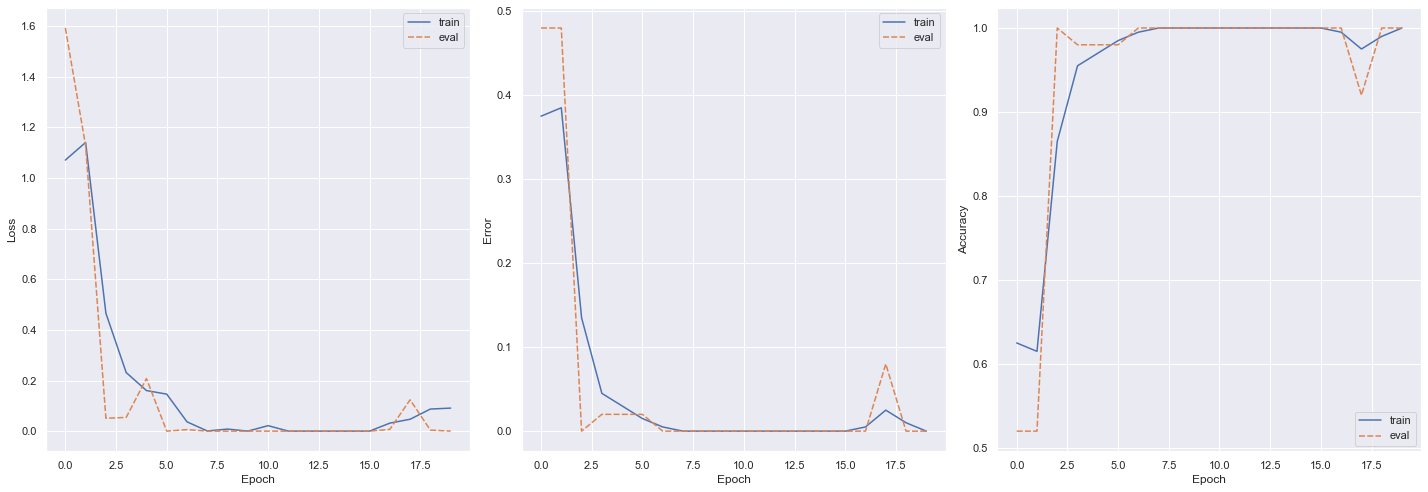

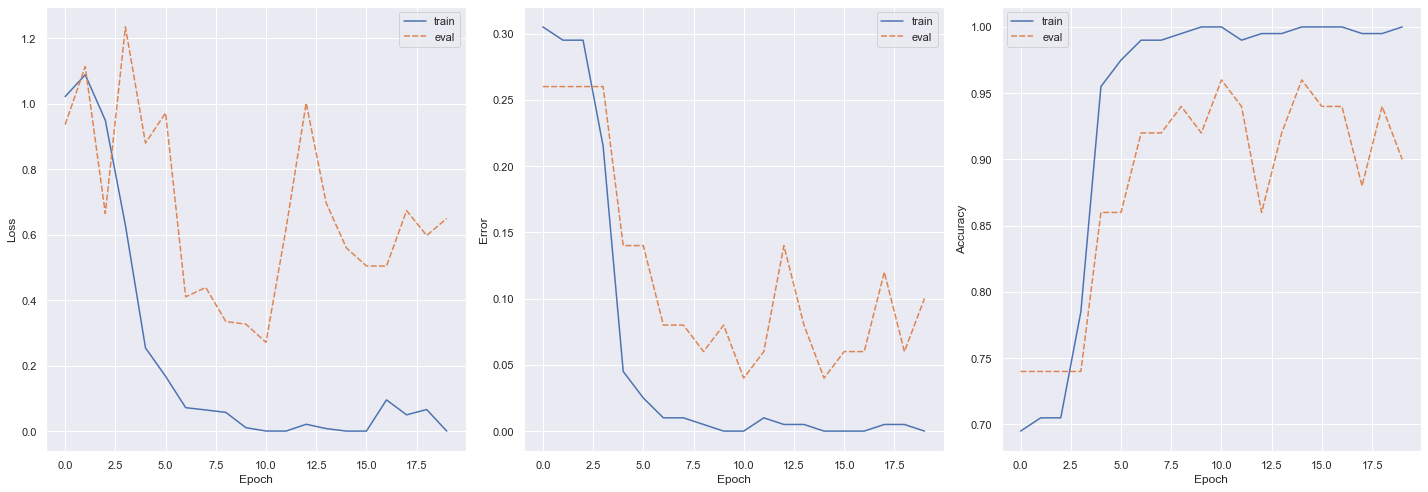

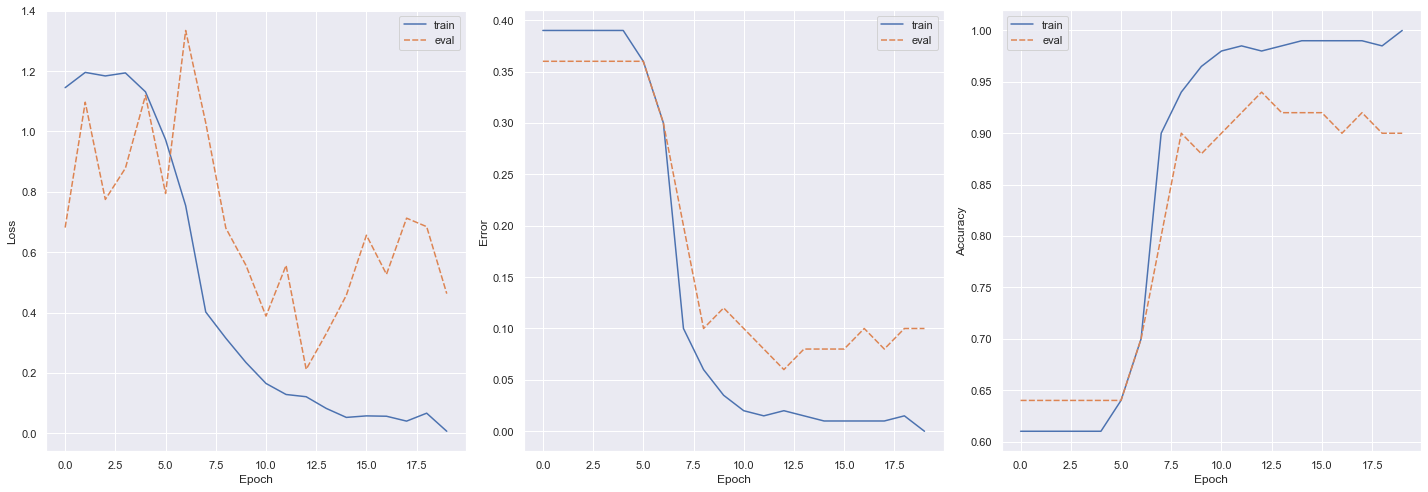

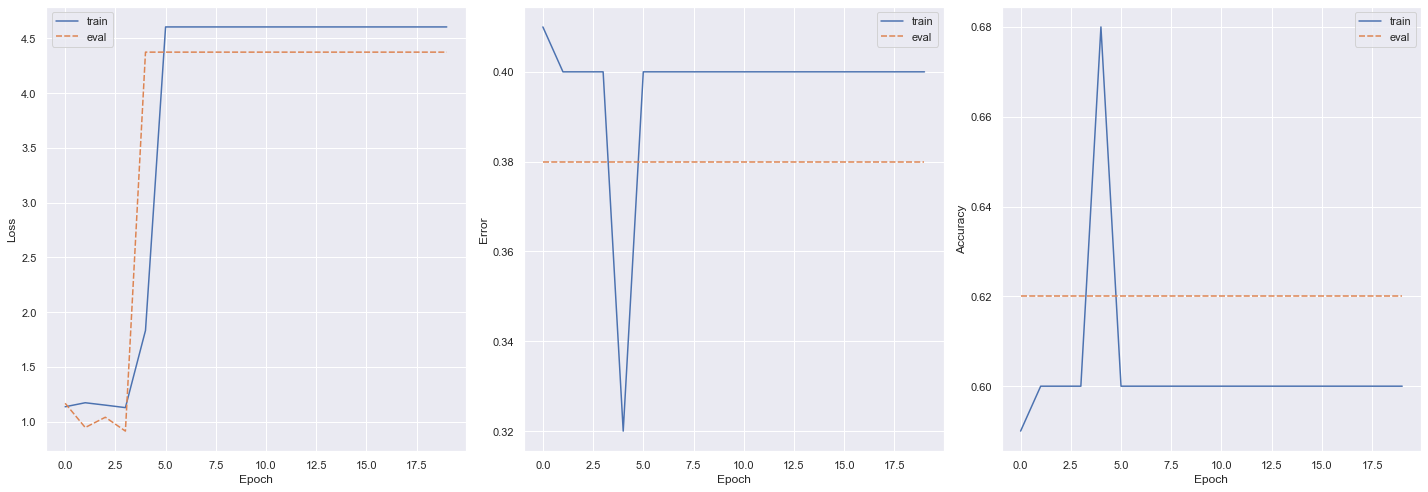

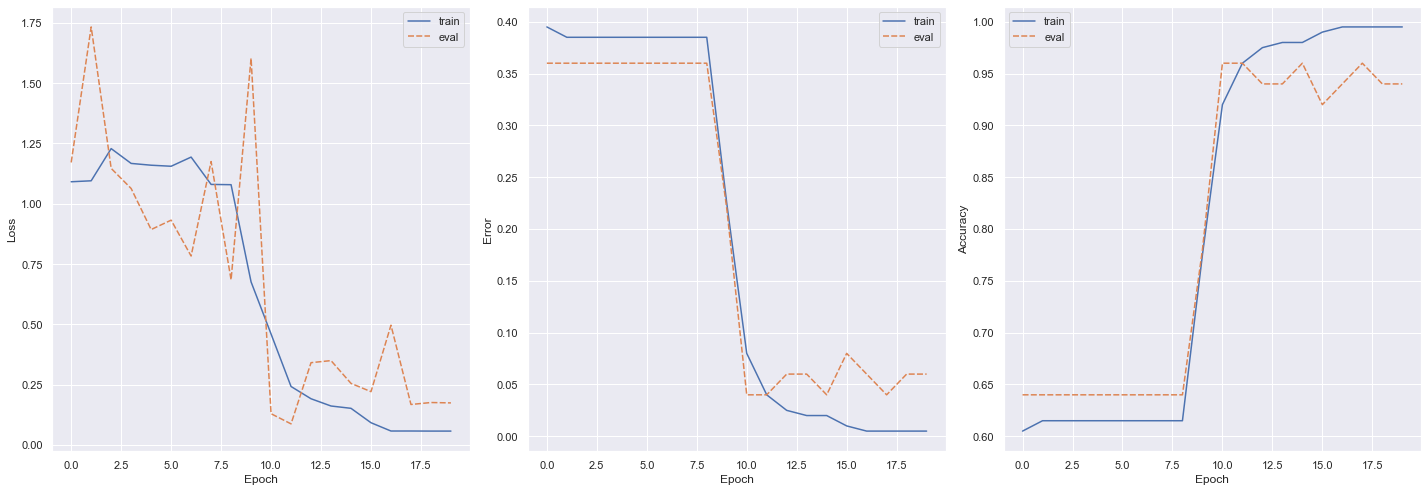

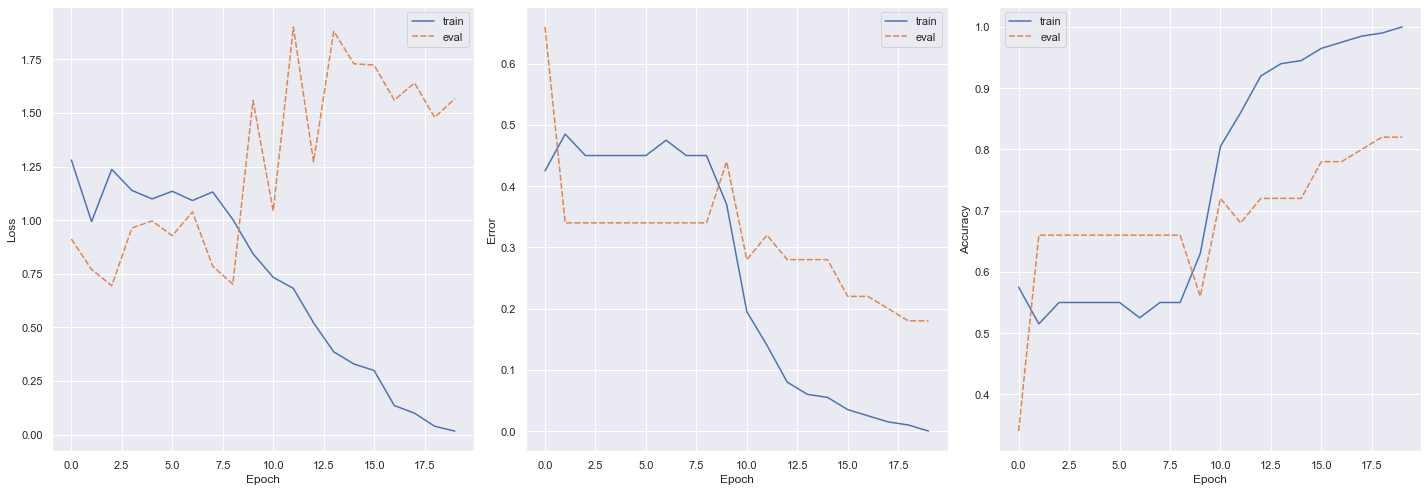

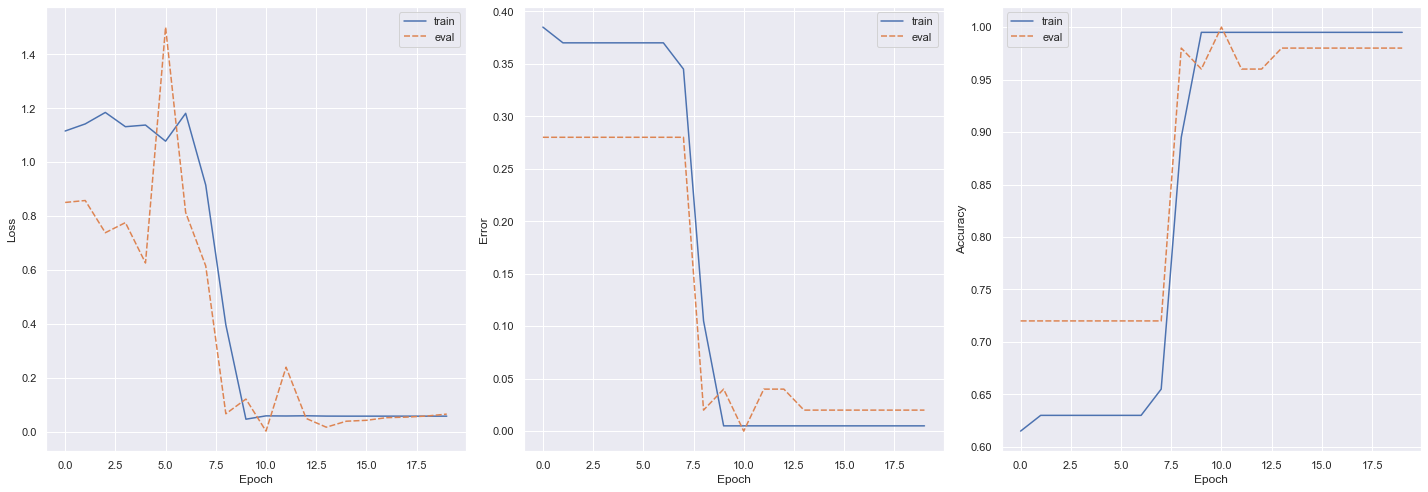

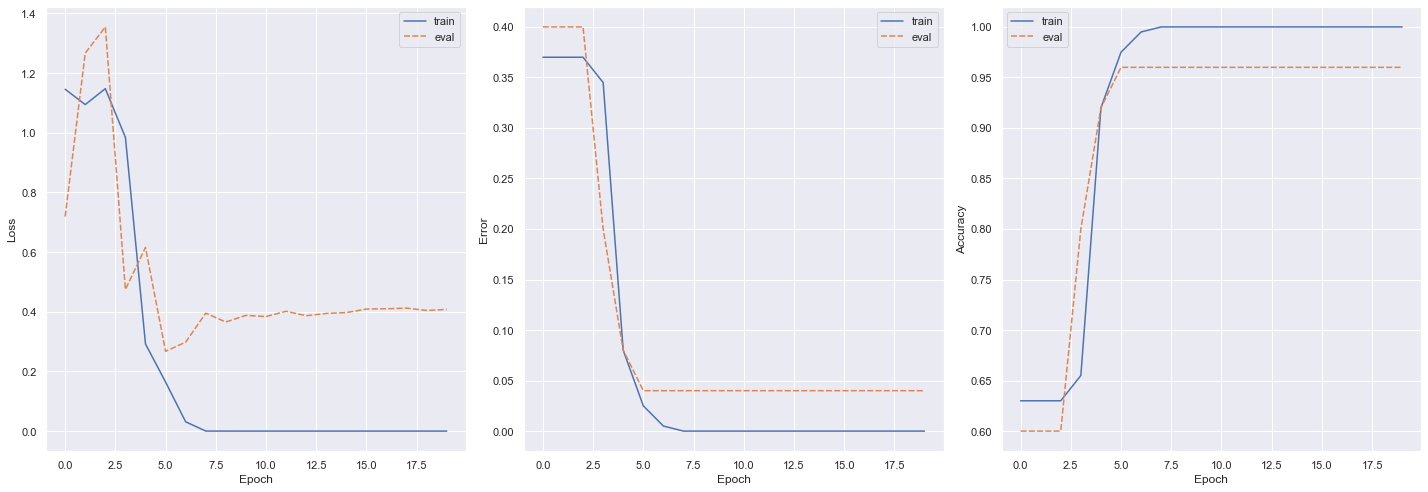

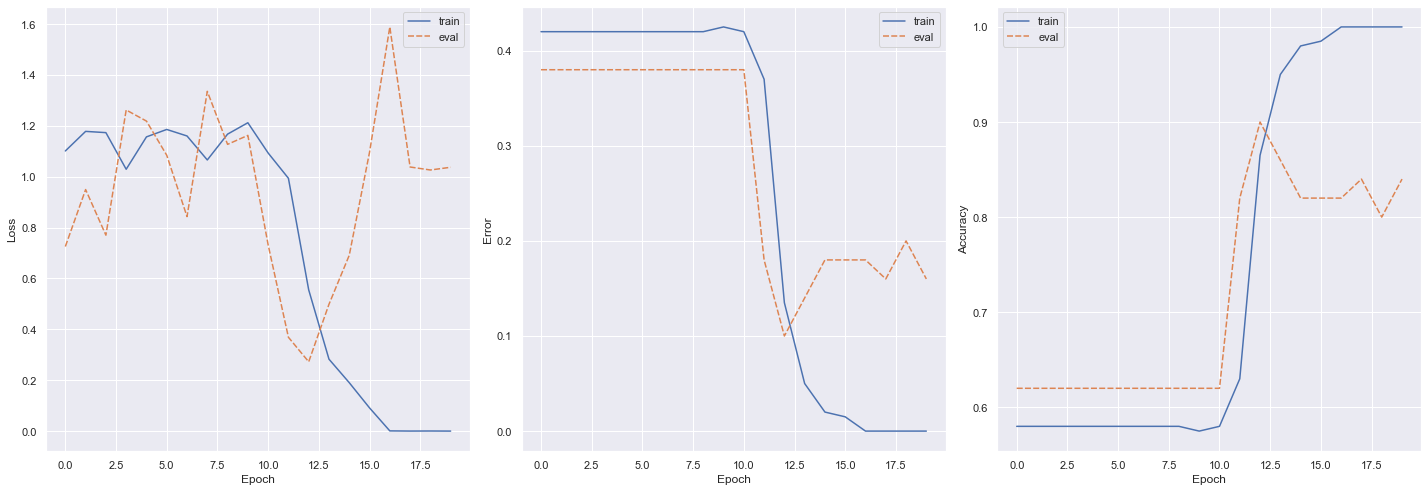

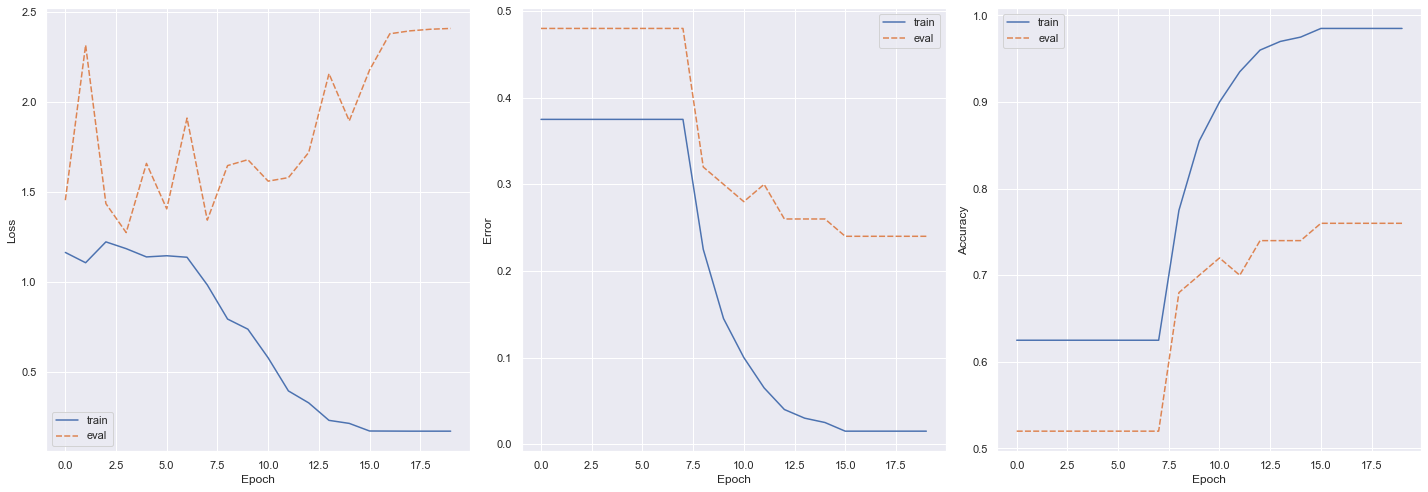

In [1000]:
full_data = pd.DataFrame({})

bag_length = 10
for digit in range(10):
    #print(digit)
    # Create data loader of training set.
    data_loader_train = DataLoader(MnistBags(
        target_number=digit,
        mean_bag_length=bag_length,
        var_bag_length=2,
        num_bag=200,
        train=True
    ), batch_size=1, shuffle=True)

    # Create data loader of validation set.
    data_loader_eval = DataLoader(MnistBags(
        target_number=digit,
        mean_bag_length=bag_length,
        var_bag_length=2,
        num_bag=50,
        train=False
    ), batch_size=1, shuffle=True)
    
    set_seed()
    network = HfPooling().to(device=device)
    optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)
    
    losses, errors, accuracies, batches = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=20)
    
    plot_performance(loss=losses, error=errors, accuracy=accuracies, log_file=f'{log_dir}/hopfield_pooling_' + str(bag_length) + '_' + str(digit) + '.pdf')
    
    matrix_similarity, bag_size, loss, error, accuracy = [], [], [], [], []

    for epoch_batch in batches['eval']:
        for instance in epoch_batch:
            matrix_similarity.append(instance[0])
            bag_size.append(instance[1])
            loss.append(instance[2])
            error.append(instance[3])
            accuracy.append(instance[4])
    
    test_df = pd.DataFrame({'similarity_value':matrix_similarity, 'bag_size':bag_size, 'loss':loss, 'error':error, 'accuracy':accuracy})
    test_df['bag_length'] = bag_length
    test_df['digit'] = digit
    
    full_data = full_data.append(test_df)
    
# bag_length = 50
# for digit in range(10):
#     #print(digit)
#     # Create data loader of training set.
#     data_loader_train = DataLoader(MnistBags(
#         target_number=digit,
#         mean_bag_length=bag_length,
#         var_bag_length=2,
#         num_bag=200,
#         train=True
#     ), batch_size=1, shuffle=True)

#     # Create data loader of validation set.
#     data_loader_eval = DataLoader(MnistBags(
#         target_number=digit,
#         mean_bag_length=bag_length,
#         var_bag_length=2,
#         num_bag=50,
#         train=False
#     ), batch_size=1, shuffle=True)
    
#     set_seed()
#     network = HfPooling().to(device=device)
#     optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)
    
#     losses, errors, accuracies, batches = operate(
#     network=network,
#     optimiser=optimiser,
#     data_loader_train=data_loader_train,
#     data_loader_eval=data_loader_eval,
#     num_epochs=20)
    
#     plot_performance(loss=losses, error=errors, accuracy=accuracies, log_file=f'{log_dir}/hopfield_pooling_' + str(bag_length) + '_' + str(digit) + '.pdf')

    
#     matrix_similarity, bag_size, loss, error, accuracy = [], [], [], [], []

#     for epoch_batch in batches['eval']:
#         for instance in epoch_batch:
#             matrix_similarity.append(instance[0])
#             bag_size.append(instance[1])
#             loss.append(instance[2])
#             error.append(instance[3])
#             accuracy.append(instance[4])
    
#     test_df = pd.DataFrame({'similarity_value':matrix_similarity, 'bag_size':bag_size, 'loss':loss, 'error':error, 'accuracy':accuracy})
#     test_df['bag_length'] = bag_length
#     test_df['digit'] = digit
    
#     full_data = full_data.append(test_df)

In [676]:
full_data.to_csv(f'{log_dir}/performized_hopfield_data.csv')

In [1013]:
stat_df = full_data[(full_data['bag_length']==10)]

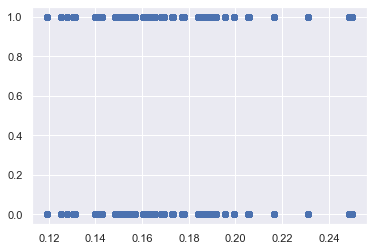

In [1015]:
plt.scatter(stat_df.similarity_value, stat_df.accuracy)

In [1037]:
stat_df['decile'] = pd.qcut(stat_df['similarity_value'], 10, labels=False)

In [1040]:
stat_df.groupby('decile').mean()[['similarity_value', 'loss', 'error', 'accuracy']]

,similarity_value,loss,error,accuracy
decile,,,,
0,0.126786,1.345878,0.240,0.760
1,0.144456,1.164035,0.213,0.787
2,0.153501,0.608288,0.178,0.822
3,0.163535,0.768071,0.171,0.829
4,0.168909,1.030858,0.226,0.774
5,0.176753,0.771307,0.131,0.869
6,0.185012,1.149195,0.220,0.780
7,0.189410,1.512419,0.259,0.741
8,0.197424,1.377408,0.240,0.760


In [1021]:
import statsmodels.api as sm

In [1025]:
Y = stat_df['loss']
X = stat_df['similarity_value']
X = sm.add_constant(X)

est=sm.OLS(Y, X)
est = est.fit()

C:\Users\Ahmed Lone\miniconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [1027]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   loss   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.004
Date:                Sun, 18 Dec 2022   Prob (F-statistic):              0.316
Time:                        21:11:59   Log-Likelihood:                -24061.
No. Observations:               10000   AIC:                         4.813e+04
Df Residuals:                    9998   BIC:                         4.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9198      0.166      5.555      0.000       0.595       1.244
similarity_value     0.9429      0.941      1.002      0.316      -0.902       2.787
==============================================================================
Omnibus:                     6097.448   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44021.181
Skew:                           3.012   Prob(JB):                         0.00
Kurtosis:                      11.329   Cond. No.                         36.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#testing batch data stuff. 

In [ ]:
test[0][0][0]

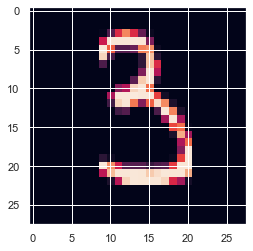

In [866]:
plt.imshow(test[0][0][0], interpolation='nearest')

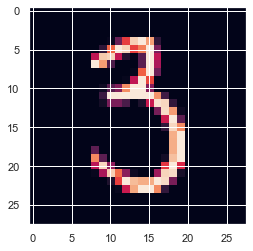

In [867]:
plt.imshow(test[0][5][0], interpolation='nearest')

In [881]:
eps = 1e-8
x = test[0][0][0] # torch.eye(28)
y = test[0][2][0] # torch.eye(28) # torch.transpose(torch.eye(10), 0, 1) * 2

x_norm = x.norm(dim=1)[:, None]
y_norm = y.norm(dim=1)[:, None]        
x_norm = x / torch.max(x_norm, eps * torch.ones_like(x_norm))
y_norm = y / torch.max(y_norm, eps * torch.ones_like(y_norm))
similarity = torch.mm(x_norm, y_norm.transpose(0, 1))
torch.mean(similarity)

tensor(0.2029)

In [441]:
similarity

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
def batch_matrix_similarity(tensor, eps=1e-8):
    matrices = []
    for matrix in tensor[0]:
        matrices.append(matrix[0])
    similarities = []
    for x, y in itertools.combinations(matrices, 2):
        x_norm = x.norm(dim=1)[:, None]
        y_norm = y.norm(dim=1)[:, None]        
        x_norm = x / torch.max(x_norm, eps * torch.ones_like(x_norm))
        y_norm = y / torch.max(y_norm, eps * torch.ones_like(y_norm))
        similarity = torch.mm(x_norm, y_norm.transpose(0, 1))
        similarities.append(torch.mean(similarity))
        #print("similarity is")
        #print(similarity)
    return float(sum(similarities) / len(similarities))


In [ ]:
#capacity experiments

In [1048]:
bag_length = 10
digit = 9

In [1049]:
data_loader_train = DataLoader(MnistBags(
    target_number=digit,
    mean_bag_length=bag_length,
    var_bag_length=2,
    num_bag=200,
    train=True
), batch_size=1, shuffle=True)

# Create data loader of validation set.
data_loader_eval = DataLoader(MnistBags(
    target_number=digit,
    mean_bag_length=bag_length,
    var_bag_length=2,
    num_bag=50,
    train=False
), batch_size=1, shuffle=True)


In [1050]:
global save_query_and_memory
global saved_queries
global saved_memories

In [1051]:
save_query_and_memory = True
saved_queries = []
saved_memories = []

In [ ]:
#Hopfield prototype 

In [1053]:
set_seed()
network = HfPooling().to(device=device)
optimiser = AdamW(params=network.parameters(), lr=5e-4, weight_decay=1e-4)

In [ ]:
losses, errors, accuracies, batch_data = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=20)

In [ ]:
plot_performance(loss=losses, error=errors, accuracy=accuracies, log_file=f'{log_dir}/hopfield_pooling.pdf')

In [1052]:
global save_memory_similarity
global saved_similarities
save_memory_similarity = False
saved_similarities = []

In [ ]:
plt.hist(saved_similarities)


In [ ]:
plt.hist(saved_similarities, weights=np.ones(len(saved_similarities)) / len(saved_similarities))
plt.xlabel("Memory Overlap")
plt.ylabel("Percent of Trials")
